In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)

In [3]:
%%time
# Read Data
basedir = './Training/training_data_ver_10/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_10.csv')
print(training_data_df.shape)
training_data_df.head()

(1649775, 529)
Wall time: 32 s


,전용면적,금액(만원),층,가격면적,target_log_transformed,targetarea_log_transformed,전용면적_mean,전용면적_min,전용면적_max,건물나이,건물나이^2,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,세대별연면적,총호수,주_용도_부대시설_있음,주_용도_주차장_있음,주_용도_복리시설_있음,주_용도_사무소_있음,주_용도_소매점_있음,주_용도_차고_있음,주_용도_일반음식점_있음,주_용도_기타제1종근생활시설_있음,주_용도_기타제2종근생활시설_있음,주_용도_기타근린생활시설_있음,주_용도_기타창고시설_있음,주_용도_기타판매시설_있음,주_용도_기타일반업무시설_있음,주_용도_기타사무소_있음,주_용도_유치원_있음,주_용도_노인복지시설_있음,주_용도_치과의원_있음,주_용도_의원_있음,주_용도_제조업소_있음,주_용도_대피소_있음,주_용도_휴게음식점_있음,주_용도_학원_있음,주_용도_생활편익시설_있음,주_용도_세탁소_있음,주_용도_창고_있음,주_용도_독서실_있음,주_용도_기타노유자시설_있음,주_용도_부동산중개업소_있음,주_용도_기원_있음,주_용도_기타교육연구시설_있음,주_용도_이(미)용원_있음,주_용도_멀티미디어문화컨텐츠설비제공업소_있음,주_용도_기타자동차관련시설_있음,주_용도_어린이집_있음,주_용도_한의원_있음,주_용도_금융업소_있음,주_용도_일반게임제공업의시설_있음,주_용도_파출소_있음,주_용도_인터넷컴퓨터게임시설제공업소_있음,주_용도_상점_있음,주_용도_게임제공업소_있음,주_용도_기타교육연구및복지시설_있음,주_용도_출판사_있음,주_용도_일반목욕장_있음,주_용도_공중화장실_있음,주_용도_부동산중개사무소_있음,주_용도_미용원_있음,주_용도_기타아동관련시설_있음,주_용도_기타공장_있음,주_용도_수리점_있음,주_용도_영유아보육시설_있음,주_용도_연구소_있음,주_용도_체육도장_있음,주_용도_지역아동센터_있음,주_용도_체육장_있음,주_용도_기타종교집회장_있음,주_용도_기타 운동시설_있음,주_용도_노래연습장_있음,주_용도_당구장_있음,주_용도_기타의료시설_있음,주_용도_아동복지시설_있음,주_용도_의약품도매점_있음,주_용도_교회_있음,주_용도_단란주점_있음,주_용도_조산원_있음,주_용도_침술원_있음,주_용도_표구점_있음,주_용도_목욕장_있음,주_용도_기타운동시설_있음,주_용도_기타문화및집회시설_있음,주_용도_기타전시장_있음,주_용도_사진관_있음,주_용도_체력단련장_있음,주_용도_가족호텔_있음,주_용도_조산소_있음,주_용도_접골원_있음,주_용도_기타생활권수련시설_있음,주_용도_기타공연장_있음,주_용도_탁구장_있음,주_용도_시장_있음,주_용도_직업훈련소_있음,주_용도_기타집회장_있음,주_용도_골프연습장_있음,주_용도_교육(연수)원_있음,주_용도_결혼상담소_있음,주_용도_인터넷컴퓨터게임시설제공업의시설_있음,주_용도_기타종교시설_있음,주_용도_사회복지시설_있음,주_용도_기타공공시설_있음,주_용도_기타판매및영업시설_있음,주_용도_사찰_있음,주_용도_의약품판매소_있음,주_용도_의료기기판매소_있음,주_용도_청소년게임제공업의시설_있음,주_용도_이용원_있음,주_용도_서점(1종근.생미해당)_있음,주_용도_기타위락시설_있음,주_용도_마을공동시설_있음,주_용도_기타위험물저장처리시설_있음,주_용도_변전소_있음,주_용도_병원_있음,주_용도_동물병원_있음,주_용도_유흥주점_있음,주_용도_예식장_있음,주_용도_기타발전시설_있음,주_용도_수퍼마켓_있음,주_용도_공공도서관_있음,주_용도_자동차영업소_있음,주_용도_분뇨처리시설_있음,주_용도_기타소매시장_있음,주_용도_온실_있음,주_용도_소매시장_있음,주_용도_안마시술소_있음,주_용도_야외극장_있음,주_용도_창고시설_있음,주_용도_에어로빅장_있음,주_용도_제2종근린생활시설_있음,주_용도_극장_있음,주_용도_한방병원_있음,주_용도_극장(영화관)_있음,주_용도_기타병원_있음,주_용도_제과점_있음,주_용도_교육연구시설_있음,주_용도_대형백화점_있음,주_용도_기타분뇨쓰레기처리시설_있음,주_용도_총포판매사_있음,주_용도_일반공장_있음,주_용도_기타공공업무시설_있음,주_용도_정수장_있음,주_용도_일반창고_있음,주_용도_운동장시설_있음,주_용도_여관_있음,주_용도_대형점_있음,주_용도_고시원_있음,주_용도_유원시설업의시설_있음,주_용도_무도장_있음,주_용도_치과병원_있음,주_용도_안마원_있음,주_용도_관광호텔_있음,주_용도_도서관_있음,주_용도_비디오물감상실_있음,주_용도_볼링장_있음,주_용도_교육원_있음,주_용도_마을공동작업소_있음,주_용도_산부인과병원_있음,주_용도_대학_있음,주_용도_주점영업_있음,주_용도_소개업_있음,주_용도_요양병원_있음,주_용도_수족관_있음,주_용도_매매장_있음,주_용도_테니스장_있음,주_용도_동사무소_있음,주_용도_무도장(학원)_있음,주_용도_대학교_있음,주_용도_호텔_있음,주_용도_운동시설_있음,주_용도_영화관_있음,주_용도_기숙사_있음,주_용도_체육관_있음,주_용도_도매시장_있음,주_용도_정비공장_있음,주_용도_복합유통게임제공업소_있음,주_용도_회의장_있음,주_용도_총포판매소_있음,주_용도_미술관_있음,주_용도_백화점_있음,주_용도_기타학교_있음,주_용도_공관_있음,주_용도_군사시설_있음,주_용도_기타제2종근린생활시설_있음,주_용도_기타제1종근린생활시설_있음,주_용도_고압가스충전저장소_있음,주_용도_초등학교_있음,주_용도_기타관광숙박시설_있음,주_용도_세차장_있음,주_용도_성당_있음,주_용도_축사_있음,주_용도_기타관광휴게시설_있음,주_용도_보건소_있음,주_용도_고등학교_있음,주_용도_다중생활시설_있음,주_용도_호스텔_있음,주_용도_생활숙박시설_있음,주_용도_청소년문화의집_있음,주_용도_산후조리원_있음,주_용도_교습소_있음,주_용도_청소년게임제공업소_있음,주_용도_야외음악당_있음,주_용도_음악당_있음,주_용도_수도원_있음,주_용도_놀이형시설_있음,주_용도_기타게임시설_있음,주_용도_제실_있음,주_용도_자치단체청사_있음,주_용도_비디오물소극장_있음,주_용도_국방ㆍ군사시설_있음,주_용도_지구대_있음,주_용도_기도원_있음,주_용도_롤러스케이트장_있음,주_용도_수영장_있음,주_용도_동물미용실_있음,주_용도_도료류판매소_있음,최빈용도,지붕_(철근)콘크리트_fraction,지붕_기타지붕_fraction,지붕_기와_fraction,지붕_슬레이트_fraction,구조_철근콘크리트구조_fraction,구조_철골철근콘크리트구조_fraction,구조_벽돌구조_fraction,구조_프리케스트콘크리트구조_fraction,구조_경량철골구조_fraction,구조_일반철골구조_fraction,구조_블록구조_fraction,구조_철골콘크리트구조_fraction,구조_일반목구조_fraction,구조_기타조적구조_fraction,구조_기타강구조_fraction,구조_기타구조_fraction,구조_기타철골철근콘크리트구조_fraction,구조_석구조_fraction,구조_강파이프구조_fraction,구조_기타콘크리트구조_fraction,...,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택 공급촉진지구,공공청사,공동구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,과밀억제권역,광로1류(폭 70M 이상),광로2류(폭 50M~70M),광로3류(폭 40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭 35M~40M),대로2류(폭 30M

<AxesSubplot:>

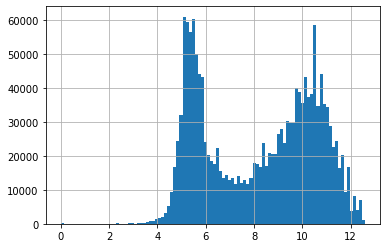

In [5]:
training_data_df['토지면적'] = training_data_df['토지면적'].apply(np.log)
training_data_df['토지면적'].hist(bins=100)

In [6]:
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

In [7]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed']#, 'land_area_log']

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

,colname
0,trade_type
1,표준지여부
2,(한강)오염행위 제한지역
3,(한강)폐기물매립시설 설치제한지역
4,가로구역별 최고높이 제한지역


In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

280

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

276

In [11]:
cat_cols

['trade_type',
 '최빈용도',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면',
 '(한강)오염행위_제한지역',
 '(한강)폐기물매립시설_설치제한지역',
 '가로구역별_최고높이_제한지역',
 '가스공급설비',
 '가축사육제한구역',
 '개발제한구역',
 '개발진흥지구',
 '개발행위허가제한지역',
 '건축선',
 '건축용도지역기타',
 '건축용도지역미분류',
 '건축허가_착공제한지역',
 '경관녹지',
 '경관지구',
 '경관지구기타',
 '고도지구',
 '고등학교',
 '고속철도',
 '공공공지',
 '공공도서관',
 '공공문화체육시설미분류',
 '공공시설구역',
 '공공주택지구',
 '공공지원민간임대주택_공급촉진지구',
 '공공청사',
 '공동구',
 '공원',
 '공원마을지구(공원집단시설지구)',
 '공원자연보존지구',
 '공원자연환경지구',
 '공익용산지',
 '공익임지',
 '공장설립승인지역',
 '공장설립제한지역',
 '공항소음피해예상지역',
 '과밀억제권역',
 '광로1류(폭_70M_이상)',
 '광로2류(폭_50M~70M)',
 '광로3류(폭_40M~50M)',
 '광역계획구역',
 '광장',
 '교육환경보호구역',
 '교통광장',
 '국가산업단지',
 '국가지정문화재구역',
 '국가하천',
 '국립공원',
 '국민임대주택단지예정지구',
 '국지도로',
 '국토이용기타용도지구',
 '국토이용용도지구기타',
 '근린공원',
 '근린광장',
 '근린상업지역',
 '기타공공공지시설',
 '기타공공청사시설',
 '기타공원시설',
 '기타교통시설',
 '기타녹지시설',
 '기타도로시설',
 '기타도시공간시설',
 '기타문화시설',
 '기타보건위생시설',
 '기타수도시설',
 '기타시장시설',
 '기타용도지역지구기타',
 '기타용지',
 '기타유통업무설비',
 '기타자동차정류장',
 '기타주차장시설',
 '기타철도시설',
 '기타폐기물처리시설',
 '노외주차장',
 '녹지'

In [12]:
training_data_df.head()

,전용면적,금액(만원),층,가격면적,target_log_transformed,targetarea_log_transformed,전용면적_mean,전용면적_min,전용면적_max,건물나이,건물나이^2,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,세대별연면적,총호수,주_용도_부대시설_있음,주_용도_주차장_있음,주_용도_복리시설_있음,주_용도_사무소_있음,주_용도_소매점_있음,주_용도_차고_있음,주_용도_일반음식점_있음,주_용도_기타제1종근생활시설_있음,주_용도_기타제2종근생활시설_있음,주_용도_기타근린생활시설_있음,주_용도_기타창고시설_있음,주_용도_기타판매시설_있음,주_용도_기타일반업무시설_있음,주_용도_기타사무소_있음,주_용도_유치원_있음,주_용도_노인복지시설_있음,주_용도_치과의원_있음,주_용도_의원_있음,주_용도_제조업소_있음,주_용도_대피소_있음,주_용도_휴게음식점_있음,주_용도_학원_있음,주_용도_생활편익시설_있음,주_용도_세탁소_있음,주_용도_창고_있음,주_용도_독서실_있음,주_용도_기타노유자시설_있음,주_용도_부동산중개업소_있음,주_용도_기원_있음,주_용도_기타교육연구시설_있음,주_용도_이(미)용원_있음,주_용도_멀티미디어문화컨텐츠설비제공업소_있음,주_용도_기타자동차관련시설_있음,주_용도_어린이집_있음,주_용도_한의원_있음,주_용도_금융업소_있음,주_용도_일반게임제공업의시설_있음,주_용도_파출소_있음,주_용도_인터넷컴퓨터게임시설제공업소_있음,주_용도_상점_있음,주_용도_게임제공업소_있음,주_용도_기타교육연구및복지시설_있음,주_용도_출판사_있음,주_용도_일반목욕장_있음,주_용도_공중화장실_있음,주_용도_부동산중개사무소_있음,주_용도_미용원_있음,주_용도_기타아동관련시설_있음,주_용도_기타공장_있음,주_용도_수리점_있음,주_용도_영유아보육시설_있음,주_용도_연구소_있음,주_용도_체육도장_있음,주_용도_지역아동센터_있음,주_용도_체육장_있음,주_용도_기타종교집회장_있음,주_용도_기타_운동시설_있음,주_용도_노래연습장_있음,주_용도_당구장_있음,주_용도_기타의료시설_있음,주_용도_아동복지시설_있음,주_용도_의약품도매점_있음,주_용도_교회_있음,주_용도_단란주점_있음,주_용도_조산원_있음,주_용도_침술원_있음,주_용도_표구점_있음,주_용도_목욕장_있음,주_용도_기타운동시설_있음,주_용도_기타문화및집회시설_있음,주_용도_기타전시장_있음,주_용도_사진관_있음,주_용도_체력단련장_있음,주_용도_가족호텔_있음,주_용도_조산소_있음,주_용도_접골원_있음,주_용도_기타생활권수련시설_있음,주_용도_기타공연장_있음,주_용도_탁구장_있음,주_용도_시장_있음,주_용도_직업훈련소_있음,주_용도_기타집회장_있음,주_용도_골프연습장_있음,주_용도_교육(연수)원_있음,주_용도_결혼상담소_있음,주_용도_인터넷컴퓨터게임시설제공업의시설_있음,주_용도_기타종교시설_있음,주_용도_사회복지시설_있음,주_용도_기타공공시설_있음,주_용도_기타판매및영업시설_있음,주_용도_사찰_있음,주_용도_의약품판매소_있음,주_용도_의료기기판매소_있음,주_용도_청소년게임제공업의시설_있음,주_용도_이용원_있음,주_용도_서점(1종근.생미해당)_있음,주_용도_기타위락시설_있음,주_용도_마을공동시설_있음,주_용도_기타위험물저장처리시설_있음,주_용도_변전소_있음,주_용도_병원_있음,주_용도_동물병원_있음,주_용도_유흥주점_있음,주_용도_예식장_있음,주_용도_기타발전시설_있음,주_용도_수퍼마켓_있음,주_용도_공공도서관_있음,주_용도_자동차영업소_있음,주_용도_분뇨처리시설_있음,주_용도_기타소매시장_있음,주_용도_온실_있음,주_용도_소매시장_있음,주_용도_안마시술소_있음,주_용도_야외극장_있음,주_용도_창고시설_있음,주_용도_에어로빅장_있음,주_용도_제2종근린생활시설_있음,주_용도_극장_있음,주_용도_한방병원_있음,주_용도_극장(영화관)_있음,주_용도_기타병원_있음,주_용도_제과점_있음,주_용도_교육연구시설_있음,주_용도_대형백화점_있음,주_용도_기타분뇨쓰레기처리시설_있음,주_용도_총포판매사_있음,주_용도_일반공장_있음,주_용도_기타공공업무시설_있음,주_용도_정수장_있음,주_용도_일반창고_있음,주_용도_운동장시설_있음,주_용도_여관_있음,주_용도_대형점_있음,주_용도_고시원_있음,주_용도_유원시설업의시설_있음,주_용도_무도장_있음,주_용도_치과병원_있음,주_용도_안마원_있음,주_용도_관광호텔_있음,주_용도_도서관_있음,주_용도_비디오물감상실_있음,주_용도_볼링장_있음,주_용도_교육원_있음,주_용도_마을공동작업소_있음,주_용도_산부인과병원_있음,주_용도_대학_있음,주_용도_주점영업_있음,주_용도_소개업_있음,주_용도_요양병원_있음,주_용도_수족관_있음,주_용도_매매장_있음,주_용도_테니스장_있음,주_용도_동사무소_있음,주_용도_무도장(학원)_있음,주_용도_대학교_있음,주_용도_호텔_있음,주_용도_운동시설_있음,주_용도_영화관_있음,주_용도_기숙사_있음,주_용도_체육관_있음,주_용도_도매시장_있음,주_용도_정비공장_있음,주_용도_복합유통게임제공업소_있음,주_용도_회의장_있음,주_용도_총포판매소_있음,주_용도_미술관_있음,주_용도_백화점_있음,주_용도_기타학교_있음,주_용도_공관_있음,주_용도_군사시설_있음,주_용도_기타제2종근린생활시설_있음,주_용도_기타제1종근린생활시설_있음,주_용도_고압가스충전저장소_있음,주_용도_초등학교_있음,주_용도_기타관광숙박시설_있음,주_용도_세차장_있음,주_용도_성당_있음,주_용도_축사_있음,주_용도_기타관광휴게시설_있음,주_용도_보건소_있음,주_용도_고등학교_있음,주_용도_다중생활시설_있음,주_용도_호스텔_있음,주_용도_생활숙박시설_있음,주_용도_청소년문화의집_있음,주_용도_산후조리원_있음,주_용도_교습소_있음,주_용도_청소년게임제공업소_있음,주_용도_야외음악당_있음,주_용도_음악당_있음,주_용도_수도원_있음,주_용도_놀이형시설_있음,주_용도_기타게임시설_있음,주_용도_제실_있음,주_용도_자치단체청사_있음,주_용도_비디오물소극장_있음,주_용도_국방ㆍ군사시설_있음,주_용도_지구대_있음,주_용도_기도원_있음,주_용도_롤러스케이트장_있음,주_용도_수영장_있음,주_용도_동물미용실_있음,주_용도_도료류판매소_있음,최빈용도,지붕_(철근)콘크리트_fraction,지붕_기타지붕_fraction,지붕_기와_fraction,지붕_슬레이트_fraction,구조_철근콘크리트구조_fraction,구조_철골철근콘크리트구조_fraction,구조_벽돌구조_fraction,구조_프리케스트콘크리트구조_fraction,구조_경량철골구조_fraction,구조_일반철골구조_fraction,구조_블록구조_fraction,구조_철골콘크리트구조_fraction,구조_일반목구조_fraction,구조_기타조적구조_fraction,구조_기타강구조_fraction,구조_기타구조_fraction,구조_기타철골철근콘크리트구조_fraction,구조_석구조_fraction,구조_강파이프구조_fraction,구조_기타콘크리트구조_fraction,...,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M

In [13]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(329955, 529)
(263964, 529)
(1055856, 529)


In [14]:
x_test = test_data.drop(columns=target_cols)
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

(329955, 525)
(329955,)


In [15]:
x_valid = valid_data.drop(columns=target_cols)
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

(263964, 525)
(263964,)


In [16]:
x_train = train_data.drop(columns=target_cols)
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

(1055856, 525)
(1055856,)


<AxesSubplot:>

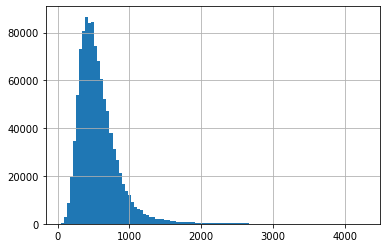

In [17]:
y_train.hist(bins=100)

# Training

In [18]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [19]:
import lightgbm as lgb

In [20]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse'
}

In [21]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [22]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=200, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.280351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7043
[LightGBM] [Info] Number of data points in the train set: 1055856, number of used features: 485


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 569.172506
Training until validation scores don't improve for 200 rounds
[50]	valid_0's rmse: 155.188
[100]	valid_0's rmse: 124.858
[150]	valid_0's rmse: 112.351
[200]	valid_0's rmse: 105.731
[250]	valid_0's rmse: 101.519
[300]	valid_0's rmse: 98.5691
[350]	valid_0's rmse: 96.1326
[400]	valid_0's rmse: 94.145
[450]	valid_0's rmse: 92.3896
[500]	valid_0's rmse: 90.9481
[550]	valid_0's rmse: 89.5805
[600]	valid_0's rmse: 88.4092
[650]	valid_0's rmse: 87.3042
[700]	valid_0's rmse: 86.3732
[750]	valid_0's rmse: 85.5678
[800]	valid_0's rmse: 84.7749
[850]	valid_0's rmse: 84.0989
[900]	valid_0's rmse: 83.4643
[950]	valid_0's rmse: 82.8868
[1000]	valid_0's rmse: 82.3336
[1050]	valid_0's rmse: 81.8137
[1100]	valid_0's rmse: 81.2694
[1150]	valid_0's rmse: 80.7745
[1200]	valid_0's rmse: 80.3001
[1250]	valid_0's rmse: 79.8277
[1300]	valid_0's rmse: 79.4119
[1350]	valid_0's rmse: 79.0206
[1400]	valid_0's rmse: 78.6426
[1450]	valid_0's rmse: 78.2702
[1500

[13050]	valid_0's rmse: 61.3794
[13100]	valid_0's rmse: 61.3582
[13150]	valid_0's rmse: 61.3397
[13200]	valid_0's rmse: 61.3238
[13250]	valid_0's rmse: 61.3059
[13300]	valid_0's rmse: 61.2867
[13350]	valid_0's rmse: 61.2687
[13400]	valid_0's rmse: 61.2484
[13450]	valid_0's rmse: 61.2347
[13500]	valid_0's rmse: 61.2165
[13550]	valid_0's rmse: 61.1945
[13600]	valid_0's rmse: 61.1768
[13650]	valid_0's rmse: 61.1603
[13700]	valid_0's rmse: 61.143
[13750]	valid_0's rmse: 61.1252
[13800]	valid_0's rmse: 61.1074
[13850]	valid_0's rmse: 61.0903
[13900]	valid_0's rmse: 61.0743
[13950]	valid_0's rmse: 61.0593
[14000]	valid_0's rmse: 61.0415
[14050]	valid_0's rmse: 61.0261
[14100]	valid_0's rmse: 61.0118
[14150]	valid_0's rmse: 60.9957
[14200]	valid_0's rmse: 60.9736
[14250]	valid_0's rmse: 60.9609
[14300]	valid_0's rmse: 60.9437
[14350]	valid_0's rmse: 60.933
[14400]	valid_0's rmse: 60.9171
[14450]	valid_0's rmse: 60.9029
[14500]	valid_0's rmse: 60.8898
[14550]	valid_0's rmse: 60.874
[14600]	val

[25900]	valid_0's rmse: 58.5553
[25950]	valid_0's rmse: 58.5475
[26000]	valid_0's rmse: 58.5417
[26050]	valid_0's rmse: 58.5324
[26100]	valid_0's rmse: 58.5274
[26150]	valid_0's rmse: 58.5221
[26200]	valid_0's rmse: 58.5163
[26250]	valid_0's rmse: 58.5102
[26300]	valid_0's rmse: 58.5056
[26350]	valid_0's rmse: 58.5005
[26400]	valid_0's rmse: 58.496
[26450]	valid_0's rmse: 58.4901
[26500]	valid_0's rmse: 58.4831
[26550]	valid_0's rmse: 58.4777
[26600]	valid_0's rmse: 58.4716
[26650]	valid_0's rmse: 58.4658
[26700]	valid_0's rmse: 58.4602
[26750]	valid_0's rmse: 58.4539
[26800]	valid_0's rmse: 58.4484
[26850]	valid_0's rmse: 58.4419
[26900]	valid_0's rmse: 58.436
[26950]	valid_0's rmse: 58.4301
[27000]	valid_0's rmse: 58.4233
[27050]	valid_0's rmse: 58.4176
[27100]	valid_0's rmse: 58.4128
[27150]	valid_0's rmse: 58.4063
[27200]	valid_0's rmse: 58.4
[27250]	valid_0's rmse: 58.3935
[27300]	valid_0's rmse: 58.3885
[27350]	valid_0's rmse: 58.3813
[27400]	valid_0's rmse: 58.3756
[27450]	valid

[38750]	valid_0's rmse: 57.378
[38800]	valid_0's rmse: 57.3753
[38850]	valid_0's rmse: 57.3726
[38900]	valid_0's rmse: 57.3692
[38950]	valid_0's rmse: 57.3653
[39000]	valid_0's rmse: 57.362
[39050]	valid_0's rmse: 57.3584
[39100]	valid_0's rmse: 57.3539
[39150]	valid_0's rmse: 57.3494
[39200]	valid_0's rmse: 57.3452
[39250]	valid_0's rmse: 57.3412
[39300]	valid_0's rmse: 57.3369
[39350]	valid_0's rmse: 57.3335
[39400]	valid_0's rmse: 57.3304
[39450]	valid_0's rmse: 57.3263
[39500]	valid_0's rmse: 57.3234
[39550]	valid_0's rmse: 57.3208
[39600]	valid_0's rmse: 57.3174
[39650]	valid_0's rmse: 57.3134
[39700]	valid_0's rmse: 57.3105
[39750]	valid_0's rmse: 57.3062
[39800]	valid_0's rmse: 57.3029
[39850]	valid_0's rmse: 57.2985
[39900]	valid_0's rmse: 57.2951
[39950]	valid_0's rmse: 57.2914
[40000]	valid_0's rmse: 57.2877
[40050]	valid_0's rmse: 57.2847
[40100]	valid_0's rmse: 57.2807
[40150]	valid_0's rmse: 57.2782
[40200]	valid_0's rmse: 57.2761
[40250]	valid_0's rmse: 57.2725
[40300]	va

[51600]	valid_0's rmse: 56.742
[51650]	valid_0's rmse: 56.7401
[51700]	valid_0's rmse: 56.7379
[51750]	valid_0's rmse: 56.7354
[51800]	valid_0's rmse: 56.7336
[51850]	valid_0's rmse: 56.7315
[51900]	valid_0's rmse: 56.7296
[51950]	valid_0's rmse: 56.7282
[52000]	valid_0's rmse: 56.727
[52050]	valid_0's rmse: 56.7245
[52100]	valid_0's rmse: 56.7223
[52150]	valid_0's rmse: 56.7203
[52200]	valid_0's rmse: 56.7197
[52250]	valid_0's rmse: 56.7188
[52300]	valid_0's rmse: 56.718
[52350]	valid_0's rmse: 56.7166
[52400]	valid_0's rmse: 56.7136
[52450]	valid_0's rmse: 56.711
[52500]	valid_0's rmse: 56.7095
[52550]	valid_0's rmse: 56.7078
[52600]	valid_0's rmse: 56.7059
[52650]	valid_0's rmse: 56.7049
[52700]	valid_0's rmse: 56.7038
[52750]	valid_0's rmse: 56.7028
[52800]	valid_0's rmse: 56.7014
[52850]	valid_0's rmse: 56.7
[52900]	valid_0's rmse: 56.6982
[52950]	valid_0's rmse: 56.6953
[53000]	valid_0's rmse: 56.6931
[53050]	valid_0's rmse: 56.6912
[53100]	valid_0's rmse: 56.6888
[53150]	valid_0

[64450]	valid_0's rmse: 56.3762
[64500]	valid_0's rmse: 56.3757
[64550]	valid_0's rmse: 56.3742
[64600]	valid_0's rmse: 56.3734
[64650]	valid_0's rmse: 56.3724
[64700]	valid_0's rmse: 56.3708
[64750]	valid_0's rmse: 56.3707
[64800]	valid_0's rmse: 56.3691
[64850]	valid_0's rmse: 56.3678
[64900]	valid_0's rmse: 56.3672
[64950]	valid_0's rmse: 56.3673
[65000]	valid_0's rmse: 56.3659
[65050]	valid_0's rmse: 56.3643
[65100]	valid_0's rmse: 56.3638
[65150]	valid_0's rmse: 56.363
[65200]	valid_0's rmse: 56.3626
[65250]	valid_0's rmse: 56.3613
[65300]	valid_0's rmse: 56.36
[65350]	valid_0's rmse: 56.3589
[65400]	valid_0's rmse: 56.3582
[65450]	valid_0's rmse: 56.3572
[65500]	valid_0's rmse: 56.3565
[65550]	valid_0's rmse: 56.3554
[65600]	valid_0's rmse: 56.3545
[65650]	valid_0's rmse: 56.3533
[65700]	valid_0's rmse: 56.3522
[65750]	valid_0's rmse: 56.3509
[65800]	valid_0's rmse: 56.3497
[65850]	valid_0's rmse: 56.3486
[65900]	valid_0's rmse: 56.3481
[65950]	valid_0's rmse: 56.3473
[66000]	val

In [23]:
import shap

In [24]:
explainer = shap.TreeExplainer(bst)

In [25]:
sample_df = x_valid.sample(n=1000)

In [26]:
shap_values = explainer.shap_values(sample_df)

In [27]:
shap_values_df = pd.DataFrame(shap_values)

In [28]:
shap_summary_df = pd.DataFrame()

In [29]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [30]:
shap_summary_df.columns = x_valid.columns

In [31]:
shap_summary_df = shap_summary_df.transpose().sort_values(0, ascending=False)
shap_summary_df.head(50)

,0
trade_type,114.207070
공시지가(만원),89.182692
건물나이,65.214936
year_linear,63.027875
전용면적,43.039059
ynorm,34.250123
토지면적,33.038386
xy,22.230673
총호수,13.645312
층,10.716494


In [32]:
over_zero_df = shap_summary_df[shap_summary_df[0] > 0]
over_zero_df.shape

(458, 1)

In [33]:
over_zero_df = over_zero_df.transpose()
over_zero_df.head()

,trade_type,공시지가(만원),건물나이,year_linear,전용면적,ynorm,토지면적,xy,총호수,층,x_2nd,토지이동상황,세대별연면적,xnorm,x_cos,전용면적_mean,전용면적_min,전용면적_max,용도지역명1,가축사육제한구역,y_2nd,지형높이,y_cos,지구단위계획구역,도로접면,아파트지구,month_sin,(한강)폐기물매립시설_설치제한지역,중점경관관리구역,정비구역,지형형상,도시지역,공원,주_용도_부대시설_있음,month_cos,도시관리계획_입안중,제2종일반주거지역,일반상업지역,재정비촉진지구,최빈용도,제1종지구단위계획구역,교육환경보호구역,건물나이^2,제3종일반주거지역,구조_벽돌구조_fraction,장애물제한표면구역,상대보호구역,주_용도_생활편익시설_있음,학교,용도지역명2,준공업지역,자연경관지구,주_용도_복리시설_있음,도로,가로구역별_최고높이_제한지역,공장설립승인지역,구조_철근콘크리트구조_fraction,자연녹지지역,지붕_(철근)콘크리트_fraction,개발행위허가제한지역,제1종일반주거지역,주_용도_사무소_있음,대공방어협조구역(위탁고도54-236m),지붕_기타지붕_fraction,공장설립제한지역,비행안전제3구역(전술),주_용도_소매점_있음,중로2류(폭_15M~20M),절대보호구역,준주거지역,제한보호구역(후방지역500m),역사도심,표준지여부,학교이적지,건축선,주_용도_유치원_있음,주_용도_기타일반업무시설_있음,소로3류(폭_8M_미만),근린공원,지역특화발전특구,주_용도_일반음식점_있음,역사문화특화경관지구,주_용도_기타제1종근린생활시설_있음,완충녹지,주_용도_노인복지시설_있음,수평표면구역,비행안전제2구역(전술),건축허가_착공제한지역,준보전산지,경관녹지,주_용도_주차장_있음,도시개발구역,공공공지,철도,비오톱1등급,대로3류(폭_25M~30M),진입표면구역,주_용도_기타제2종근린생활시설_있음,원추표면구역,대공방어협조구역,고도지구,어린이공원,지붕_기와_fraction,주_용도_골프연습장_있음,도시기타용도지역지구미분류,구조_블록구조_fraction,중요시설물보호지구(공항),소로2류(폭_8M~10M),도시기타용도지역지구기타,소로1류(폭_10M~12M),하천구역,구조_철골철근콘크리트구조_fraction,도시철도,구조_경량철골구조_fraction,주_용도_목욕장_있음,기타철도시설,광로2류(폭_50M~70M),구조_철골콘크리트구조_fraction,공공청사,제1종전용주거지역,제한보호구역(전술항공5km),재개발구역,과밀억제권역,주_용도_상점_있음,녹지,주_용도_기타판매시설_있음,방화지구,건축용도지역기타,지하도로,용도구역기타,광장,주_용도_기타종교시설_있음,주_용도_기타근린생활시설_있음,보행자전용도로,주_용도_기타노유자시설_있음,정비구역기타,택지개발예정지구,보전산지,일반철도,주_용도_시장_있음,주_용도_학원_있음,공공주택지구,주_용도_대피소_있음,중로3류(폭_12M~15M),주_용도_기타종교집회장_있음,산업시설구역,구조_기타조적구조_fraction,주_용도_기타제1종근생활시설_있음,대공방어협조구역(위탁고도77-257m),주_용도_휴게음식점_있음,비행안전제6구역(전술),구조_일반철골구조_fraction,대로1류(폭_35M~40M),주_용도_의원_있음,공항소음피해예상지역,사업지역기타,주_용도_의료기기판매소_있음,국민임대주택단지예정지구,토지거래계약에관한허가구역,도시자연공원구역,조례로정한지역,문화재보호구역,경관지구기타,공익용산지,주_용도_기타사무소_있음,근린광장,주_용도_기타_운동시설_있음,기타녹지시설,일단의주택단지조성사업지역,주_용도_영유아보육시설_있음,역사문화미관지구,제3종_구역,중요시설물보호지구(공용),자동차정류장,지목명,중로1류(폭_20M~25M),구조_일반목구조_fraction,주_용도_교육원_있음,재정비촉진지구기타,주_용도_제조업소_있음,유수지,주_용도_체력단련장_있음,x_sin,주_용도_일반목욕장_있음,주_용도_독서실_있음,도시지역기타,문화재보존영향_검토대상구역,주_용도_기타교육연구및복지시설_있음,구조_기타콘크리트구조_fraction,하수도,주차장,시장,기타공원시설,광로3류(폭_40M~50M),사회복지시설,유통업무설비,공동구,용도구역미분류,주_용도_노래연습장_있음,주_용도_기타의료시설_있음,주_용도_교회_있음,주_용도_부동산중개업소_있음,주_용도_공중화장실_있음,비행안전제2구역(지원),주_용도_관광호텔_있음,주_용도_한의원_있음,연결녹지,하천,산업개발진흥지구,기타도로시설,주_용도_기타아동관련시설_있음,국토이용용도지구기타,조망가로특화경관지구,주_용도_병원_있음,구조_기타강구조_fraction,고속철도,대로2류(폭_30M~35M),주_용도_금융업소_있음,주_용도_기타창고시설_있음,제한보호구역,주_용도_어린이집_있음,연구개발특구,지붕_슬레이트_fraction,도로구역,주_용도_교육(연수)원_있음,주_용도_당구장_있음,주_용도_서점(1종근.생미해당)_있음,주_용도_이(미)용원_있음,체육시설,비행안전제5구역(지원),구조_기타구조_fraction,구조_프리케스트콘크리트구조_fraction,주_용도_기타판매및영업시설_있음,주_용도_기타제2종근생활시설_있음,주_용도_체육도장_있음,주_용도_부동산중개사무소_있음,주_용도_기타운동시설_있음,전통사찰보존구역,택지개발예정지구기타,주_용도_인터넷컴퓨터게임시설제공업의시설_있음,현상변경허가_대상구역,주_용도_기타문화및집회시설_있음,주_용도_의약품판매소_있음,비행안전제5구역(전술),주_용도_사진관_있음,주차환경개선지구,개발제한구역,주거환경개선지구,사방지,종합의료시설,문화시설,주_용도_미용원_있음,소공원,근린상업지역,주_용도_운동장시설_있음,생산녹지지역,정비예정구역,주_용도_기타교육연구시설_있음,역사문화환경보존지역,주_용도_예식장_있음,전기공급설비,주_용도_창고_있음,중학교,경관지구,광로1류(폭_70M_이상),주_용도_세탁소_있음,시장정비구역,주_용도_유흥주점_있음,주_용도_에어로빅장_있음,온천공보호구역,자연재해위험지구,(한강)오염행위_제한지역,도서관,비행안전제3구역(지원),주_용도_수퍼마켓_있음,유치원,주_용도_파출소_있음,주_용도_기원_있음,주_용도_정수장_있음,특정개발진흥지구,부설주차장,일반주거지역,보전임지,국가하천,초등학교,방수설비,주_용도_게임제공업소_있음,주_용도_초등학교_있음,운동장,광역계획구역,야생생물보호구역,사방시설,침수위험지구,연구시설,주_용도_기타공공시설_있음,주_용도_사회복지시설_있음,주_용도_극장_있음,주_용도_교습소_있음,주_용도_공공도서관_있음,임업용산지,주_용도_치과의원_있음,지원시설구역,고등학교,국가산업단지,주_용도_동사무소_있음,주_용도_볼링장_있음,주_용도_마을공동시설_있음,교통광장,주_용도_일반창고_있음,국립공원,주_용도_가족호텔_있음,일반도로,공익임지,주_용도_수리점_있음,주_용도_기타발전시설_있음,수도공급시설,주_용도_체육장_있음,문화지구,공공도서관,주_용도_사찰_있음,유통단지,주_용도_대형점_있음,주거용지,지정문화재구역,공공지원민간임대주택_공급촉진지구,주_용도_운동시설_있음,여객자동차터미널,특화경관지구,청소년수련시설,지하광장,특수도로(보행자전용도로),주간선도로,도시개발구역기타,주_용도_기타자동차관련시설_있음,제방,주_용도_고시원_있음,주_용도_자동차영업소_있음,중심대광장,유통상업지역,주_용도_도서관_있음,주_용도_정비공장_있음,주_용도_기타전시장_있음,주_용도_수영장_있음,국지도로,구조_강파이프구조_fraction,주_용도_제과점_있음,주_용도_변전소_있음,기타문화시설,주_용도_기타소매시장_있음,주_용도_기타분뇨쓰레기처리시설_있음,주_용도_기타공공업무시설_있음,제2종전용주거지역,주_용도_놀이형시설_있음,주_용도_축사_있음,공원자연환경지구,비행안전제4구역(지원),주_용도_탁구장_있음,주_용도_롤러스케이트장_있음,주_용도_극장(영화관)_있음,국가지정문화재구역,노외주차장,주_용도_기타공장_있음,주_용도_의약품도매점_있음,주_용도_멀티미디어문화컨텐츠설비제공업소_있음,주_용도_체육관_있음,주_용도_기타공연장_있음,주_용도_차고_있음,기타자동차정류장,일단의공업용지조성사업지역,공공문화체육시설미분류,도시자연공원,주_용도_인터넷컴퓨터게임시설제공업소_있음,문화재,주_용도_복합유통게임제공업소_있음,주_용도_일반게임제공업의시설_있음,기타시장시설,주_용도_조산소_있음,기타도시공간시설,소

In [34]:
selected_features = over_zero_df.columns.tolist()

In [35]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(329955, 529)
(263964, 529)
(1055856, 529)


In [36]:
x_test = test_data[selected_features]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

(329955, 458)
(329955,)


In [37]:
x_valid = valid_data[selected_features]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

(263964, 458)
(263964,)


In [38]:
x_train = train_data[selected_features]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

(1055856, 458)
(1055856,)


<AxesSubplot:>

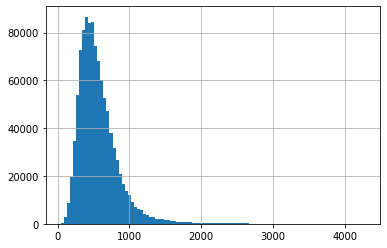

In [39]:
y_train.hist(bins=100)

In [45]:
import lightgbm as lgb

In [50]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse',
    'tree_learner':'feature'
}

In [51]:
cat_cols = [col for col in cat_cols if col in selected_features]
len(cat_cols)

250

In [52]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [53]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=5000, verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.371972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6761
[LightGBM] [Info] Number of data points in the train set: 1055856, number of used features: 456
[LightGBM] [Info] Start training from score 568.923624
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's rmse: 156.273
[100]	valid_0's rmse: 126.007
[150]	valid_0's rmse: 113.31
[200]	valid_0's rmse: 106.473
[250]	valid_0's rmse: 102.127
[300]	valid_0's rmse: 99.0142
[350]	valid_0's rmse: 96.4599
[400]	valid_0's rmse: 94.3969
[450]	valid_0's rmse: 92.749
[500]	valid_0's rmse: 91.2392
[550]	valid_0's rmse: 89.8675
[600]	valid_0's rmse: 88.7317
[650]	valid_0's rmse: 87.6972
[700]	valid_0's rmse: 86.7577
[750]	valid_0's rmse: 85.9086
[800]	valid_0's rmse: 85.1256
[850]	valid_0's rmse: 84.3812
[900]	valid_0's 

[12500]	valid_0's rmse: 61.7657
[12550]	valid_0's rmse: 61.7444
[12600]	valid_0's rmse: 61.7274
[12650]	valid_0's rmse: 61.7071
[12700]	valid_0's rmse: 61.6871
[12750]	valid_0's rmse: 61.6635
[12800]	valid_0's rmse: 61.6412
[12850]	valid_0's rmse: 61.6224
[12900]	valid_0's rmse: 61.6058
[12950]	valid_0's rmse: 61.5865
[13000]	valid_0's rmse: 61.5694
[13050]	valid_0's rmse: 61.551
[13100]	valid_0's rmse: 61.5346
[13150]	valid_0's rmse: 61.5201
[13200]	valid_0's rmse: 61.5
[13250]	valid_0's rmse: 61.4834
[13300]	valid_0's rmse: 61.4664
[13350]	valid_0's rmse: 61.4471
[13400]	valid_0's rmse: 61.4307
[13450]	valid_0's rmse: 61.4143
[13500]	valid_0's rmse: 61.3937
[13550]	valid_0's rmse: 61.3745
[13600]	valid_0's rmse: 61.3561
[13650]	valid_0's rmse: 61.3389
[13700]	valid_0's rmse: 61.318
[13750]	valid_0's rmse: 61.3003
[13800]	valid_0's rmse: 61.2811
[13850]	valid_0's rmse: 61.2645
[13900]	valid_0's rmse: 61.2504
[13950]	valid_0's rmse: 61.2295
[14000]	valid_0's rmse: 61.214
[14050]	valid_

[25350]	valid_0's rmse: 58.8009
[25400]	valid_0's rmse: 58.7915
[25450]	valid_0's rmse: 58.7867
[25500]	valid_0's rmse: 58.7797
[25550]	valid_0's rmse: 58.7744
[25600]	valid_0's rmse: 58.7676
[25650]	valid_0's rmse: 58.7598
[25700]	valid_0's rmse: 58.7533
[25750]	valid_0's rmse: 58.7452
[25800]	valid_0's rmse: 58.7379
[25850]	valid_0's rmse: 58.7289
[25900]	valid_0's rmse: 58.721
[25950]	valid_0's rmse: 58.7128
[26000]	valid_0's rmse: 58.7063
[26050]	valid_0's rmse: 58.6997
[26100]	valid_0's rmse: 58.6938
[26150]	valid_0's rmse: 58.6866
[26200]	valid_0's rmse: 58.6805
[26250]	valid_0's rmse: 58.6736
[26300]	valid_0's rmse: 58.6686
[26350]	valid_0's rmse: 58.6619
[26400]	valid_0's rmse: 58.6563
[26450]	valid_0's rmse: 58.6512
[26500]	valid_0's rmse: 58.6451
[26550]	valid_0's rmse: 58.6404
[26600]	valid_0's rmse: 58.6334
[26650]	valid_0's rmse: 58.6281
[26700]	valid_0's rmse: 58.6216
[26750]	valid_0's rmse: 58.6163
[26800]	valid_0's rmse: 58.6092
[26850]	valid_0's rmse: 58.6034
[26900]	v

[38200]	valid_0's rmse: 57.5745
[38250]	valid_0's rmse: 57.5702
[38300]	valid_0's rmse: 57.5675
[38350]	valid_0's rmse: 57.5636
[38400]	valid_0's rmse: 57.56
[38450]	valid_0's rmse: 57.5574
[38500]	valid_0's rmse: 57.5554
[38550]	valid_0's rmse: 57.5525
[38600]	valid_0's rmse: 57.55
[38650]	valid_0's rmse: 57.5464
[38700]	valid_0's rmse: 57.5429
[38750]	valid_0's rmse: 57.539
[38800]	valid_0's rmse: 57.5348
[38850]	valid_0's rmse: 57.5316
[38900]	valid_0's rmse: 57.5283
[38950]	valid_0's rmse: 57.5253
[39000]	valid_0's rmse: 57.5227
[39050]	valid_0's rmse: 57.5197
[39100]	valid_0's rmse: 57.5143
[39150]	valid_0's rmse: 57.512
[39200]	valid_0's rmse: 57.5087
[39250]	valid_0's rmse: 57.5049
[39300]	valid_0's rmse: 57.5019
[39350]	valid_0's rmse: 57.4989
[39400]	valid_0's rmse: 57.4971
[39450]	valid_0's rmse: 57.4935
[39500]	valid_0's rmse: 57.4911
[39550]	valid_0's rmse: 57.49
[39600]	valid_0's rmse: 57.4861
[39650]	valid_0's rmse: 57.4824
[39700]	valid_0's rmse: 57.4802
[39750]	valid_0'

[51100]	valid_0's rmse: 56.9133
[51150]	valid_0's rmse: 56.9117
[51200]	valid_0's rmse: 56.9108
[51250]	valid_0's rmse: 56.9085
[51300]	valid_0's rmse: 56.9063
[51350]	valid_0's rmse: 56.9041
[51400]	valid_0's rmse: 56.9023
[51450]	valid_0's rmse: 56.9006
[51500]	valid_0's rmse: 56.8991
[51550]	valid_0's rmse: 56.8964
[51600]	valid_0's rmse: 56.8935
[51650]	valid_0's rmse: 56.8922
[51700]	valid_0's rmse: 56.8899
[51750]	valid_0's rmse: 56.8871
[51800]	valid_0's rmse: 56.885
[51850]	valid_0's rmse: 56.8831
[51900]	valid_0's rmse: 56.8819
[51950]	valid_0's rmse: 56.8801
[52000]	valid_0's rmse: 56.877
[52050]	valid_0's rmse: 56.8747
[52100]	valid_0's rmse: 56.8727
[52150]	valid_0's rmse: 56.8707
[52200]	valid_0's rmse: 56.8685
[52250]	valid_0's rmse: 56.8662
[52300]	valid_0's rmse: 56.8639
[52350]	valid_0's rmse: 56.8624
[52400]	valid_0's rmse: 56.8599
[52450]	valid_0's rmse: 56.8574
[52500]	valid_0's rmse: 56.8558
[52550]	valid_0's rmse: 56.8536
[52600]	valid_0's rmse: 56.851
[52650]	val

[63950]	valid_0's rmse: 56.516
[64000]	valid_0's rmse: 56.5157
[64050]	valid_0's rmse: 56.5146
[64100]	valid_0's rmse: 56.5137
[64150]	valid_0's rmse: 56.5133
[64200]	valid_0's rmse: 56.5126
[64250]	valid_0's rmse: 56.5114
[64300]	valid_0's rmse: 56.511
[64350]	valid_0's rmse: 56.5101
[64400]	valid_0's rmse: 56.51
[64450]	valid_0's rmse: 56.5091
[64500]	valid_0's rmse: 56.5076
[64550]	valid_0's rmse: 56.5068
[64600]	valid_0's rmse: 56.5057
[64650]	valid_0's rmse: 56.5045
[64700]	valid_0's rmse: 56.5037
[64750]	valid_0's rmse: 56.5032
[64800]	valid_0's rmse: 56.5025
[64850]	valid_0's rmse: 56.501
[64900]	valid_0's rmse: 56.5
[64950]	valid_0's rmse: 56.4987
[65000]	valid_0's rmse: 56.4974
[65050]	valid_0's rmse: 56.496
[65100]	valid_0's rmse: 56.4951
[65150]	valid_0's rmse: 56.4939
[65200]	valid_0's rmse: 56.4926
[65250]	valid_0's rmse: 56.4902
[65300]	valid_0's rmse: 56.4895
[65350]	valid_0's rmse: 56.4887
[65400]	valid_0's rmse: 56.4873
[65450]	valid_0's rmse: 56.4866
[65500]	valid_0's

[76850]	valid_0's rmse: 56.2928
[76900]	valid_0's rmse: 56.2921
[76950]	valid_0's rmse: 56.2916
[77000]	valid_0's rmse: 56.2912
[77050]	valid_0's rmse: 56.2916
[77100]	valid_0's rmse: 56.2916
[77150]	valid_0's rmse: 56.2911
[77200]	valid_0's rmse: 56.2905
[77250]	valid_0's rmse: 56.2899
[77300]	valid_0's rmse: 56.2894
[77350]	valid_0's rmse: 56.2889
[77400]	valid_0's rmse: 56.2868
[77450]	valid_0's rmse: 56.2864
[77500]	valid_0's rmse: 56.2849
[77550]	valid_0's rmse: 56.2844
[77600]	valid_0's rmse: 56.2836
[77650]	valid_0's rmse: 56.2827
[77700]	valid_0's rmse: 56.2818
[77750]	valid_0's rmse: 56.281
[77800]	valid_0's rmse: 56.2799
[77850]	valid_0's rmse: 56.2793
[77900]	valid_0's rmse: 56.2789
[77950]	valid_0's rmse: 56.278
[78000]	valid_0's rmse: 56.2777
[78050]	valid_0's rmse: 56.2767
[78100]	valid_0's rmse: 56.2759
[78150]	valid_0's rmse: 56.2747
[78200]	valid_0's rmse: 56.2728
[78250]	valid_0's rmse: 56.2717
[78300]	valid_0's rmse: 56.2709
[78350]	valid_0's rmse: 56.2704
[78400]	va

[89750]	valid_0's rmse: 56.1379
[89800]	valid_0's rmse: 56.1372
[89850]	valid_0's rmse: 56.1366
[89900]	valid_0's rmse: 56.1361
[89950]	valid_0's rmse: 56.1357
[90000]	valid_0's rmse: 56.1357
[90050]	valid_0's rmse: 56.1358
[90100]	valid_0's rmse: 56.1349
[90150]	valid_0's rmse: 56.1337
[90200]	valid_0's rmse: 56.1334
[90250]	valid_0's rmse: 56.1331
[90300]	valid_0's rmse: 56.133
[90350]	valid_0's rmse: 56.1327
[90400]	valid_0's rmse: 56.1327
[90450]	valid_0's rmse: 56.1325
[90500]	valid_0's rmse: 56.1316
[90550]	valid_0's rmse: 56.1312
[90600]	valid_0's rmse: 56.1303
[90650]	valid_0's rmse: 56.1298
[90700]	valid_0's rmse: 56.1294
[90750]	valid_0's rmse: 56.129
[90800]	valid_0's rmse: 56.1284
[90850]	valid_0's rmse: 56.1279
[90900]	valid_0's rmse: 56.1276
[90950]	valid_0's rmse: 56.1274
[91000]	valid_0's rmse: 56.1273
[91050]	valid_0's rmse: 56.1266
[91100]	valid_0's rmse: 56.1259
[91150]	valid_0's rmse: 56.1257
[91200]	valid_0's rmse: 56.1251
[91250]	valid_0's rmse: 56.1252
[91300]	va

[102550]	valid_0's rmse: 56.0395
[102600]	valid_0's rmse: 56.039
[102650]	valid_0's rmse: 56.0386
[102700]	valid_0's rmse: 56.0382
[102750]	valid_0's rmse: 56.0376
[102800]	valid_0's rmse: 56.037
[102850]	valid_0's rmse: 56.0363
[102900]	valid_0's rmse: 56.0357
[102950]	valid_0's rmse: 56.0354
[103000]	valid_0's rmse: 56.0349
[103050]	valid_0's rmse: 56.0344
[103100]	valid_0's rmse: 56.0339
[103150]	valid_0's rmse: 56.0337
[103200]	valid_0's rmse: 56.0332
[103250]	valid_0's rmse: 56.0324
[103300]	valid_0's rmse: 56.0325
[103350]	valid_0's rmse: 56.0322
[103400]	valid_0's rmse: 56.032
[103450]	valid_0's rmse: 56.0318
[103500]	valid_0's rmse: 56.0316
[103550]	valid_0's rmse: 56.0312
[103600]	valid_0's rmse: 56.0308
[103650]	valid_0's rmse: 56.0308
[103700]	valid_0's rmse: 56.0304
[103750]	valid_0's rmse: 56.0301
[103800]	valid_0's rmse: 56.0298
[103850]	valid_0's rmse: 56.0301
[103900]	valid_0's rmse: 56.0303
[103950]	valid_0's rmse: 56.0301
[104000]	valid_0's rmse: 56.0306
[104050]	vali

[115050]	valid_0's rmse: 55.9931
[115100]	valid_0's rmse: 55.9931
[115150]	valid_0's rmse: 55.993
[115200]	valid_0's rmse: 55.9927
[115250]	valid_0's rmse: 55.9927
[115300]	valid_0's rmse: 55.9925
[115350]	valid_0's rmse: 55.9919
[115400]	valid_0's rmse: 55.9912
[115450]	valid_0's rmse: 55.991
[115500]	valid_0's rmse: 55.9907
[115550]	valid_0's rmse: 55.9904
[115600]	valid_0's rmse: 55.9903
[115650]	valid_0's rmse: 55.9901
[115700]	valid_0's rmse: 55.9897
[115750]	valid_0's rmse: 55.9892
[115800]	valid_0's rmse: 55.989
[115850]	valid_0's rmse: 55.9887
[115900]	valid_0's rmse: 55.9886
[115950]	valid_0's rmse: 55.9886
[116000]	valid_0's rmse: 55.9886
[116050]	valid_0's rmse: 55.9884
[116100]	valid_0's rmse: 55.988
[116150]	valid_0's rmse: 55.9879
[116200]	valid_0's rmse: 55.9877
[116250]	valid_0's rmse: 55.9874
[116300]	valid_0's rmse: 55.9873
[116350]	valid_0's rmse: 55.9875
[116400]	valid_0's rmse: 55.9874
[116450]	valid_0's rmse: 55.9874
[116500]	valid_0's rmse: 55.9872
[116550]	valid

[127500]	valid_0's rmse: 55.9648
[127550]	valid_0's rmse: 55.9652
[127600]	valid_0's rmse: 55.965
[127650]	valid_0's rmse: 55.9647
[127700]	valid_0's rmse: 55.9647
[127750]	valid_0's rmse: 55.964
[127800]	valid_0's rmse: 55.9639
[127850]	valid_0's rmse: 55.9641
[127900]	valid_0's rmse: 55.9641
[127950]	valid_0's rmse: 55.9641
[128000]	valid_0's rmse: 55.9643
[128050]	valid_0's rmse: 55.9642
[128100]	valid_0's rmse: 55.9641
[128150]	valid_0's rmse: 55.9641
[128200]	valid_0's rmse: 55.9638
[128250]	valid_0's rmse: 55.9634
[128300]	valid_0's rmse: 55.9631
[128350]	valid_0's rmse: 55.9627
[128400]	valid_0's rmse: 55.9628
[128450]	valid_0's rmse: 55.9626
[128500]	valid_0's rmse: 55.9629
[128550]	valid_0's rmse: 55.9631
[128600]	valid_0's rmse: 55.9629
[128650]	valid_0's rmse: 55.963
[128700]	valid_0's rmse: 55.9627
[128750]	valid_0's rmse: 55.9625
[128800]	valid_0's rmse: 55.9622
[128850]	valid_0's rmse: 55.9621
[128900]	valid_0's rmse: 55.9618
[128950]	valid_0's rmse: 55.9617
[129000]	vali

In [ ]:
lgb.plot_importance(bst)

In [ ]:
preds = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
bst.save_model('lgb_model_for_training_data_ver_8.txt')

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_training_data_ver_8.csv', index=False)

In [ ]:
pd.DataFrame({'preds':preds}).to_csv('lgb_preds_training_data_ver_8.csv', index=False)

In [ ]:
y_test_pricearea = test_data['가격/면적']

In [ ]:
r2_score(y_test, preds)

In [ ]:
r2_score(y_test_pricearea, np.e**preds)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, preds)

In [ ]:
mean_squared_error(y_test_pricearea, np.e**preds)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'preds':preds})
print(compare_df.shape)
compare_df.head(50)

In [ ]:
compare_df.tail()

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.01)#, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)

In [ ]:
%%time
shap_values = model.get_feature_importance(data=val_pool, type='ShapValues')

In [ ]:
shap_values.shape

In [ ]:
val_pool.shape

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
colnames_map_df = pd.DataFrame({'colnames':x_valid.columns,'map':[i for i in range(len(x_valid.columns))]})
colnames_map_df.head()

In [ ]:
x_valid.columns = colnames_map_df['map'].tolist()
x_valid.head()

In [ ]:
summary = shap.summary_plot(shap_values[:,:-1], x_valid, max_display=x_valid.shape[1])

In [ ]:
shap_values_df = pd.DataFrame(shap_values[:,:-1])
shap_values_df.head()

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
np.mean(np.abs(shap_values_df[0].values))

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values([0], ascending=False)

In [ ]:
shap_summary_df.head()

In [ ]:
selected_features_map = shap_summary_df.index[:330].values

In [ ]:
selected_features_list = []
for v in selected_features_map:
    selected_features_list.append(colnames_map_df.iloc[v,0])

In [ ]:
selected_features_list

In [ ]:
selected_features_df = pd.DataFrame({'colnames':selected_features_list})
selected_features_df.head()

In [ ]:
selected_features_df.to_csv(basedir + 'selected_features.csv', index=False)

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features_list]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features_list]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features_list]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

In [ ]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

In [ ]:
cat_cols = [col for col in x_train.columns if col in cat_cols_list]
len(cat_cols)

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.001, depth=7, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)